In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
import xscale


from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/docrep/__init__.py:413: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents(s)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/docrep/__init__.py:342: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#print(cluster.job_script())
#print(cluster.job_header)
w = cluster.scale(28*3)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/docrep/__init__.py:342: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.25:59686 Dashboard: http://10.148.1.25:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


_________
# 1. Read dataset


In [5]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

ds_KPP = xr.open_zarr(out_dir_zarr+'KPPhbl_total_rechunk.zarr')
print(ds_KPP)

<xarray.Dataset>
Dimensions:  (lat: 201, lon: 177, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Dimensions without coordinates: lat, lon
Data variables:
    KPPhbl   (time, lat, lon) float32 dask.array<shape=(9415, 201, 177), chunksize=(9415, 201, 177)>


In [9]:
wt = ds_KPP.KPPhbl.window
wt.set()

cutoff_time = 48 # A 48-hour cutoff
dx_time = 1 # Define the sampling period (one hour)
wt.set(n=80, dim='time', cutoff=cutoff_time, dx=dx_time, window='hanning')

mld_filter = wt.convolve(trim=True)
mld_filter = np.real(mld_filter).rename('mld_filter')
mld_filter

<xarray.DataArray 'mld_filter' (time: 9415, lat: 201, lon: 177)>
dask.array<shape=(9415, 201, 177), dtype=float32, chunksize=(9415, 201, 177)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Dimensions without coordinates: lat, lon

In [11]:
mld_filter = np.real(mld_filter).rename('mld_filter')
mld_filter = mld_filter.to_dataset()
file_out = out_dir_zarr+'/mld_filter.zarr'
%time mld_filter.to_zarr(file_out, mode='w')   

CPU times: user 1.53 s, sys: 108 ms, total: 1.64 s
Wall time: 45.9 s


# 2. MLD_filter

In [18]:
ds = xr.open_zarr(out_dir_zarr+'mld_filter.zarr')
print(ds)

<xarray.Dataset>
Dimensions:     (lat: 201, lon: 177, time: 9415)
Coordinates:
  * time        (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Dimensions without coordinates: lat, lon
Data variables:
    mld_filter  (time, lat, lon) float32 dask.array<shape=(9415, 201, 177), chunksize=(9415, 201, 177)>


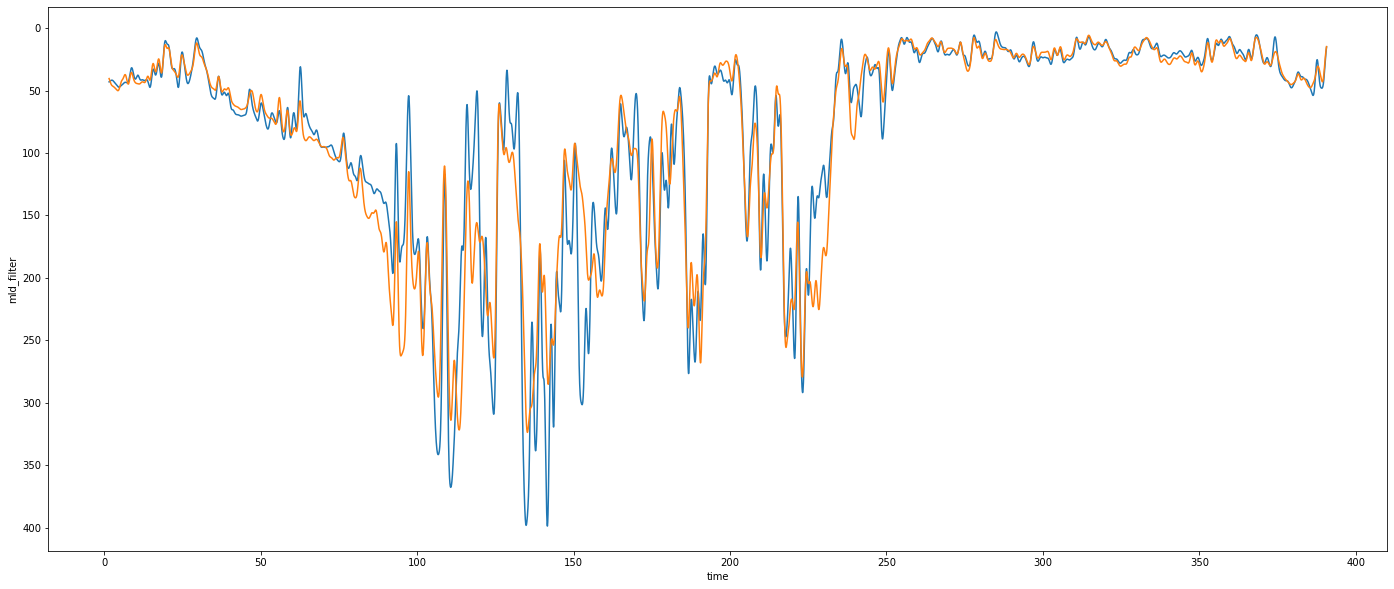

In [19]:
fig = plt.figure(figsize=(24,10))
ds.mld_filter.isel(lat=100,lon=100).plot(x='time', yincrease=False)
ds.mld_filter.mean(['lat','lon']).plot(x='time', yincrease=False)

In [21]:
cluster.scheduler.close()

<Future finished result=None>